In [1]:
import pathlib, os, shutil, cv2
import numpy as np

"""
    source: source images directory
    destination: destination images directory
    angle: rotate angle
    cascadeClassifier: default face detection config,
        link: https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
"""
def extract_image(source, destination, angle, cascadeClassifier, cropped=True):
    vidcap = cv2.VideoCapture(source)

    success, image = vidcap.read()
    count, failed_count = 0, 0
    success = True
    while success:
        file_name = "frame%d.jpg" % count
        file = os.path.join(destination, file_name)
        raw_portrait_image = _rotate_image(image, angle)
        
        # whether face detection needed or not
        if cropped == True:
            portrait_image = detect_crop_face(raw_portrait_image, cascadeClassifier)
            if portrait_image is None:
                failed_count += 1
                print('photo generated failed at {}'.format(count))
            else:
                cv2.imwrite(file, portrait_image)     # save frame as JPEG file
        else:
            cv2.imwrite(file, raw_portrait_image)
        
        success, image = vidcap.read() 
        if count % 100 == 0:
            print("Generated: {} photos in {}".format(count, destination))
        count += 1
    print('Total generated {} photos'.format(count - failed_count))
    
def _rotate_image(image, angle):
    # rotate image some degree
    height, width = image.shape[:2]
    image_center = (width/2, height/2)
    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    rotated_image = cv2.warpAffine(image, rotation_mat, (bound_w, bound_h))
    return rotated_image

"""
    Detect face in image, extract and return the face image.
    image: the raw photo which contains the face
    faceCascade: face cascade xml config file,
        link: https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
"""
def detect_crop_face(image, faceCascade):
    face_cascade = cv2.CascadeClassifier(faceCascade)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if faces == ():
        return None
    else:
        for (x,y,w,h) in faces:
            return image[y:y+h, x:x+w]

In [2]:
def img_to_array(source_folder_path, y_label, target_image_width, target_image_height, RGB=True):
    if RGB == True:
        channels = 3
    else:
        channels = 1
    total_item = len(os.listdir(source_folder_path))
    counter = 1
    X = np.empty((1, target_image_width * target_image_height * channels))
    y = np.full((total_item, 1), y_label)
    for file_name in os.listdir(source_folder_path):
        file = os.path.join(source_folder_path, file_name)
        image = cv2.imread(file)
        reshaped_image = cv2.resize(image, (target_image_width, target_image_height))
        reshaped_image_1d = reshaped_image.reshape(1, -1)
        if counter == 1:
            X = reshaped_image_1d
        else:
            X = np.concatenate((X, reshaped_image_1d))
        counter += 1
    return X, y

In [21]:
import numpy as np
import os, cv2

source_folder_path='/Users/xingdawang/Movies/xingda/'
y_label = 0
target_image_width, target_image_height = 150, 150
xingda_X, xingda_y = img_to_array(
    source_folder_path = source_folder_path,
    y_label = y_label,
    target_image_width = target_image_width,
    target_image_height = target_image_height)

In [22]:
source_folder_path='/Users/xingdawang/Movies/julie/'
y_label = 1
target_image_width, target_image_height = 150, 150
julie_X, julie_y = img_to_array(
    source_folder_path = source_folder_path,
    y_label = y_label,
    target_image_width = target_image_width,
    target_image_height = target_image_height)

In [23]:
source_folder_path='/Users/xingdawang/Movies/melanie/'
y_label = 2
target_image_width, target_image_height = 150, 150
melanie_X, melanie_y = img_to_array(
    source_folder_path = source_folder_path,
    y_label = y_label,
    target_image_width = target_image_width,
    target_image_height = target_image_height)

In [24]:
# Concatenate result X & y
X_input = np.concatenate((np.concatenate((xingda_X, julie_X)), melanie_X))
y_input = np.concatenate((np.concatenate((xingda_y, julie_y)), melanie_y))

# Reset and scale X & y shape
X_input_raw = X_input / 255.
y_input_raw = y_input.reshape(-1)

# shuffle X & y with predictable result
index = np.random.choice(np.arange(len(y_input_raw)), len(y_input_raw), replace=False)
X_input = X_input_raw[index]
y_input = y_input_raw[index]

In [25]:
# X_input = X_input.astype(np.float32) / 255.

X_train, X_test = X_input[:250], X_input[250:300]
y_train, y_test = y_input[:250], y_input[250:300]
X_train, X_valid = X_train[:200], X_train[200:250]
y_train, y_valid = y_train[:200], y_train[200:259]

In [26]:
print("Train X shape:\t\t", X_train.shape)
print("Validation X shape:\t", X_valid.shape)
print("Test X shape:\t\t", X_test.shape)
print("Train y shape:\t\t", y_train.shape)
print("Validation y shape:\t", y_valid.shape)
print("Test y shape:\t\t", y_valid.shape)

Train X shape:		 (200, 67500)
Validation X shape:	 (50, 67500)
Test X shape:		 (50, 67500)
Train y shape:		 (200,)
Validation y shape:	 (50,)
Test y shape:		 (50,)


In [52]:
import numpy as np
import tensorflow as tf

width, height = 150, 150
n_outputs = 3
channels = 3
n_inputs = height * width * channels
tf.reset_default_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name = "X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape = [None], name = "y")
    
with tf.name_scope('conv32_layer'):
#     conv shape: [mini-batch size, height, width, channels]
    conv32_1 = tf.layers.conv2d(inputs=X_reshaped, filters=32, kernel_size=[3, 3], padding='same', activation=tf.nn.relu, name='conv32_1')
    conv32_2 = tf.layers.conv2d(inputs=conv32_1, filters=32, kernel_size=[3, 3], activation=tf.nn.relu)
    max_pool32_1 = tf.layers.max_pooling2d(conv32_2, pool_size=[2, 2], strides=2)
    dropout32_1 = tf.layers.dropout(inputs=max_pool32_1, rate=0.25)
    
with tf.name_scope('conv64_layer'):
    conv64_1 = tf.layers.conv2d(inputs=dropout32_1, filters=64, kernel_size=[3, 3], activation=tf.nn.relu)
    conv64_2 = tf.layers.conv2d(inputs=conv64_1, filters=64, kernel_size=[3, 3], activation=tf.nn.relu)
    max_pool64_1 = tf.layers.max_pooling2d(conv64_2, pool_size=[2, 2], strides=2)
    dropout64_1 = tf.layers.dropout(inputs=max_pool64_1, rate=0.25)

with tf.name_scope('conv128_layer'):
    conv128_1 = tf.layers.conv2d(inputs=dropout64_1, filters=128, kernel_size=[3, 3], activation=tf.nn.relu)
    max_pool128_1 = tf.layers.max_pooling2d(conv128_1, pool_size=[2, 2], strides=2)
    dropout128_1 = tf.layers.dropout(inputs=max_pool128_1, rate=0.25)
    conv128_2 = tf.layers.conv2d(inputs=dropout128_1, filters=128, kernel_size=[3, 3], activation=tf.nn.relu)
    max_pool128_2 = tf.layers.max_pooling2d(conv128_2, pool_size=[2, 2], strides=2)
    dropout128_2 = tf.layers.dropout(inputs=max_pool128_2, rate=0.25)
    
with tf.name_scope('conv256_layer'):
    conv256_1 = tf.layers.conv2d(inputs=dropout128_2, filters=256, kernel_size=[3, 3], activation=tf.nn.relu)
    max_pool256_1 = tf.layers.max_pooling2d(conv256_1, pool_size=[2, 2], strides=2)
    dropout256_1 = tf.layers.dropout(inputs=max_pool256_1, rate=0.25)

with tf.name_scope("outputs_layer"):
    outputs_layer_reshaped = tf.layers.flatten(dropout256_1)
    outputs_layer512_1 = tf.layers.dense(outputs_layer_reshaped, 512, activation=tf.nn.relu)
    outputs_dropout_1 = tf.layers.dropout(inputs=outputs_layer512_1, rate=0.5, name='output')
    logits = tf.layers.dense(outputs_dropout_1, n_outputs, activation=tf.nn.relu)
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [53]:
from time import time
n_epoch = 20
batch_size = 16

def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

acc_batch_list = []
acc_test_list = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epoch):
        time_before_batch = time()
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        time_after_batch = time()
        # Calculate the elapsed time
        time_elapsed = time_after_batch - time_before_batch
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_batch_list.append(acc_batch)
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        acc_test_list.append(acc_test)
        print("Epoch", epoch, "Time cost: %.2f" % time_elapsed, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./test")

Epoch 0 Time cost: 11.04 Last batch accuracy: 0.6875 Test accuracy: 0.62
Epoch 1 Time cost: 10.76 Last batch accuracy: 0.6875 Test accuracy: 0.76
Epoch 2 Time cost: 11.52 Last batch accuracy: 0.4375 Test accuracy: 0.74
Epoch 3 Time cost: 10.95 Last batch accuracy: 0.875 Test accuracy: 0.94
Epoch 4 Time cost: 10.74 Last batch accuracy: 0.8125 Test accuracy: 0.74
Epoch 5 Time cost: 10.77 Last batch accuracy: 1.0 Test accuracy: 0.94
Epoch 6 Time cost: 10.49 Last batch accuracy: 0.9375 Test accuracy: 1.0
Epoch 7 Time cost: 10.51 Last batch accuracy: 1.0 Test accuracy: 0.92
Epoch 8 Time cost: 10.45 Last batch accuracy: 1.0 Test accuracy: 0.98
Epoch 9 Time cost: 10.59 Last batch accuracy: 1.0 Test accuracy: 0.98
Epoch 10 Time cost: 10.65 Last batch accuracy: 1.0 Test accuracy: 1.0
Epoch 11 Time cost: 10.86 Last batch accuracy: 1.0 Test accuracy: 1.0
Epoch 12 Time cost: 10.57 Last batch accuracy: 1.0 Test accuracy: 1.0
Epoch 13 Time cost: 10.38 Last batch accuracy: 1.0 Test accuracy: 1.0
Epoc

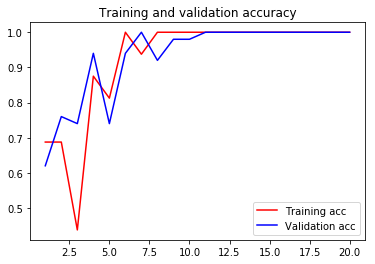

In [54]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc_batch_list) + 1)

plt.plot(epochs, acc_batch_list, 'r', label='Training acc')
plt.plot(epochs, acc_test_list, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.show()

INFO:tensorflow:Restoring parameters from ./test
[[1.0379201e-01 3.2760518e-06 8.9620471e-01]]


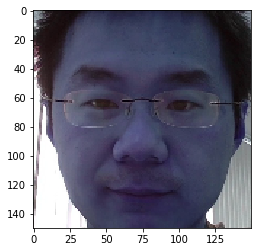

In [60]:
import tensorflow as tf
import cv2

tf.reset_default_graph()


# test
image = cv2.imread('/Users/xingdawang/Desktop/xingda/frame31.jpg')
image = cv2.resize(image, (150, 150), cv2.INTER_LINEAR)
X_batch = image.reshape(-1, 150 * 150 * 3)
X_batch = X_batch / 255.
y_batch = np.zeros((1, 1)).reshape(-1)

with tf.Session() as sess:
    #First let's load meta graph and restore weights
    saver = tf.train.import_meta_graph('test.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    # Now, let's access and create placeholders variables and create feed-dict to feed new data
    # Check tensor name
    # [n.name for n in tf.get_default_graph().as_graph_def().node]
    graph = tf.get_default_graph()
    X_placeholder = graph.get_tensor_by_name("inputs/X:0")
    y_placeholder = graph.get_tensor_by_name("inputs/y:0")
#     print(X_placeholder.shape)
#     print(y_placeholder.shape)

    # Now, access the training op that you want to run. 
    Y_proba = graph.get_tensor_by_name("outputs_layer/Y_proba:0")
    dict = {X_placeholder: X_batch, y_placeholder: y_batch}

    result = sess.run(Y_proba, feed_dict = dict)
    print(result)

recovered_img = X_batch
plt.imshow(recovered_img.reshape(150, 150, 3))

In [62]:
# no data augmentation, generalize bad, too lazy!
# 没有做数据扩展，泛化贼差，懒得一逼

In [65]:
# data augmentation link: 
# https://medium.com/ymedialabs-innovation/data-augmentation-techniques-in-cnn-using-tensorflow-371ae43d5be9